## Conditional Variational Encoder aka CVAE

We will use 2-dim hidden vectors for approximation of parameters $\mu$, $\log\sigma^2$ of normal distribution. 

We'll also encode image representation using information about their classes, that will allow us to generate images of a certain class sampling hidden variables from a $P(z|c)$

Useful reference: https://wiseodd.github.io/techblog/2016/12/17/conditional-vae/

In [513]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np
import os 

%matplotlib inline

In [514]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [515]:
root_folder = 'Conv_VAE_log_results'
fixed_folder = root_folder + '/Fixed_results'
AE_folder = root_folder + '/AE_results'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)
os.mkdir(AE_folder)

In [516]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

In [517]:
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_tanh)

In [518]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU(), stride=1):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding, stride=stride))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [519]:
class DeconvLayer(nn.Module):
    def __init__(self, size, padding=1, stride=1, 
                 bn=False, dropout=False, activation_fn=nn.ReLU(), output_padding=0):
        super(DeconvLayer, self).__init__()
        layers = []
        layers.append(nn.ConvTranspose2d(size[0], size[1], size[2], padding=padding, 
                                         stride=stride, output_padding=output_padding))
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [520]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh):
        super(FullyConnected, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [521]:
class Net(nn.Module):
    def __init__(self, latent_size=32, gamma=1e-3, batchnorm=False, dropout=False, optim_type='SGD', **optim_params):
        super(Net, self).__init__()
    
        self.latent_size = latent_size
        self.gamma = gamma
        
        self._conv1 = ConvLayer([1, 16, 4], padding=0, bn=batchnorm, stride=2, pool_layer=None)
        self._conv2 = ConvLayer([16, 32, 4], padding=0, bn=batchnorm, stride=2, pool_layer=None)
        self._conv3 = ConvLayer([32, 32, 3], padding=0, bn=batchnorm, stride=2, pool_layer=None)
        
        self.fce_class = nn.Sequential(nn.Linear(10, 128), 
                                       nn.ReLU(inplace=True),
                                       nn.BatchNorm1d(128),
                                       )
            
        self.fce = FullyConnected([32*2*2 + 128, latent_size*2])  # added a function g1(c) of a digit class c
        
        
        self.fcd_class = nn.Sequential(nn.Linear(latent_size + 10, 128),
                                       nn.ReLU(inplace=True),
                                       nn.BatchNorm1d(128),  
                                       )
        self.fcd = FullyConnected([128, 32*2*2])    # added a function g2(c) of a digit class c
        
        self._deconv1 = DeconvLayer([32, 32, 3], stride=2, padding=0, bn=batchnorm)
        self._deconv2 = DeconvLayer([32, 16, 4], stride=2, padding=0, bn=batchnorm, output_padding=1)
        self._deconv3 = DeconvLayer([16, 1, 4], stride=2, padding=0, bn=batchnorm, activation_fn=nn.Tanh())
        
        self._loss = None
        if optim_type == 'SGD':
            self.optim = optim.SGD(self.parameters(), **optim_params)
        elif optim_type == 'Adadelta':
            self.optim = optim.Adadelta(self.parameters(), **optim_params)
        elif optim_type == 'RMSProp':
            self.optim = optim.RMSprop(self.parameters(), **optim_params)
        elif optim_type == 'Adam':
            self.optim = optim.Adam(self.parameters(), **optim_params)
        
    def conv(self, x):
        l1 = self._conv1(x)
        l2 = self._conv2(l1)
        l3 = self._conv3(l2)
        return l3, l2, l1
    
    def encode(self, x, c):
        """ Note: Added c: class of a digit """
        # Let's process an image through conv layers
        l3 = self.conv(x)[0]
        flatten = l3.view(-1, 32*2*2)
        
        c = self.fce_class(c)   # g1(c)
        
        # Process a class through FC layer as well
        flatten = torch.cat([flatten, c], dim=1)
        h = self.fce(flatten)             
        
        self.mu, self.logvar = h.split(self.latent_size, dim=1)
        return self.mu, self.logvar
    
    def decode(self, h, c):
        """ Note: Added c: class of a digit """
        h = torch.cat([h, c], dim=1)
        
        flatten = self.fcd_class(h)   # g2(c)
        
        flatten = self.fcd(flatten)
        l1 = flatten.view(-1, 32, 2, 2)
        l2 = self._deconv1(l1)
        l3 = self._deconv2(l2)
        x = self._deconv3(l3)
        return x
    
    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        if self.training:
            std = logvar.mul(0.5).exp()
            h = self._sample(mu.shape[0]) * std + mu
        else:
            h = mu
        x = self.decode(h, c)
        return x
    
    def _sample(self, n):
        return torch.randn([n, self.latent_size])
    
    def loss(self, output, target, size_average=True):
        """ The loss is rest the same """
        KLD = self.mu**2 + self.logvar.exp() - 1 - self.logvar
        KLD = 0.5*KLD.sum(1)
        if size_average:
            self.KLD = KLD.mean()
        else:
            self.KLD = KLD.sum()
        self._loss = F.mse_loss(output, target, size_average=size_average)
        
        return self._loss + self.gamma*self.KLD

Set latent size is equal to 2

In [522]:
latent_size = 2
fixed_z = torch.randn((100, latent_size))
fixed_z.shape

torch.Size([100, 2])

In [523]:
# z ~ N(0, 1)
fixed_z[0]

tensor([ 1.5044,  1.2092])

Form an array that constists of class' indices, shape=(100,) 

In [524]:
torch.range(0, 9, dtype=torch.int64).view(1, -1).t()

tensor([[ 0],
        [ 1],
        [ 2],
        [ 3],
        [ 4],
        [ 5],
        [ 6],
        [ 7],
        [ 8],
        [ 9]])

In [525]:
# array of class' indicies
fixed_z_c = torch.cat([torch.range(0, 9, dtype=torch.int64).view(1, -1).t() for i in range(0, 10)], 0).view(100,)
fixed_z_c.shape

torch.Size([100])

In [526]:
fixed_z_c[:15]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2,  3,
         4])

In [527]:
# check the loader
fixed_data, fixed_classes = next(iter(test_loader))

In [528]:
fixed_classes[:15]

tensor([ 7,  2,  1,  0,  4,  1,  4,  9,  5,  9,  0,  6,  9,  0,
         1])

In [529]:
def one_hot(batch, depth):
    emb = nn.Embedding(depth, depth)
    emb.weight.data = torch.eye(depth)
    return emb(batch)

In [530]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, targets) in enumerate(train_loader):  # <-- here we use class (target)
        c = one_hot(targets, 10)
        for model in models.values():
            model.optim.zero_grad()
            output = model(data, c)
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss,))
        print(line + losses)

In [531]:
def test(models, loader, epoch, log=None):
    test_size = len(loader)
    test_reconstruction_loss = {k: 0. for k in models}
    test_KL_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, targets in loader:
            c = one_hot(targets, 10)
            output = {k: m(data, c) for k, m in models.items()}
            for k, m in models.items():
                m.loss(output[k], data)
                test_reconstruction_loss[k] += m._loss.item()
                test_KL_loss[k] += m.KLD.item()
    
    for k in models:
        test_reconstruction_loss[k] /= test_size
        test_KL_loss[k] /= test_size
    report = 'Test losses: ' + ' '.join(['{}: {:.4f}/{:.4f}'.format(k, 
                                                                    test_reconstruction_loss[k], 
                                                                    test_KL_loss[k]) for k in models])
    for k in models:
        if log is not None:
            log[k].append((test_reconstruction_loss[k], test_KL_loss[k]))
        with torch.no_grad():
            print("Reconstructed images:")
            ae_data = models[k](fixed_data, one_hot(fixed_classes, 10)).data.numpy()
            plot_mnist(ae_data, (10, 10), True, AE_folder + '/%s_%03d.png' % (k, epoch))
            
            # We will generate 100 digits from random vectors, conditioning them with 10 classes,
            # So we have 10 different digits at each step using 'fixed_z_c' [0, 1, 2, ..., 9, 0, 1, 2, ...] of size (100, )
            print('Generated images:')
            fixed_gen = models[k].decode(fixed_z, one_hot(fixed_z_c, 10)).data.numpy()
            plot_mnist(fixed_gen, (10, 10), True, fixed_folder + '/%s_%03d.png' % (k, epoch))
    print(report)

In [532]:
# models = {'CVAE_2': Net(latent_size=latent_size, gamma=0.001, batchnorm=False, dropout=False, optim_type='Adam', lr=1e-4)}
models = {'CVAE_2': Net(latent_size=latent_size, gamma=0.01, batchnorm=False, dropout=False, optim_type='Adam', lr=1e-4)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

Train Epoch: 1 [0/50000 (0%)]	Losses CVAE_2: 0.9641
Train Epoch: 1 [10000/50000 (20%)]	Losses CVAE_2: 0.6397
Train Epoch: 1 [20000/50000 (40%)]	Losses CVAE_2: 0.5208
Train Epoch: 1 [30000/50000 (60%)]	Losses CVAE_2: 0.4395
Train Epoch: 1 [40000/50000 (80%)]	Losses CVAE_2: 0.3366
Train Epoch: 1 [50000/50000 (100%)]	Losses CVAE_2: 0.3225
Reconstructed images:


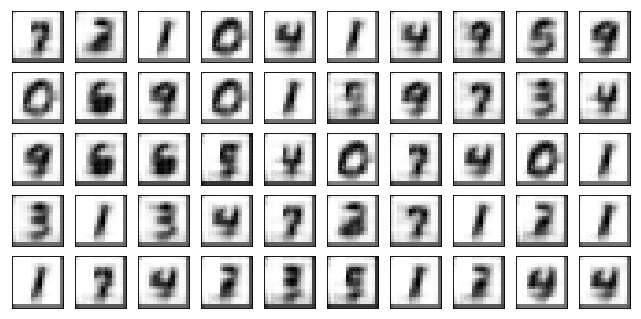

Generated images:


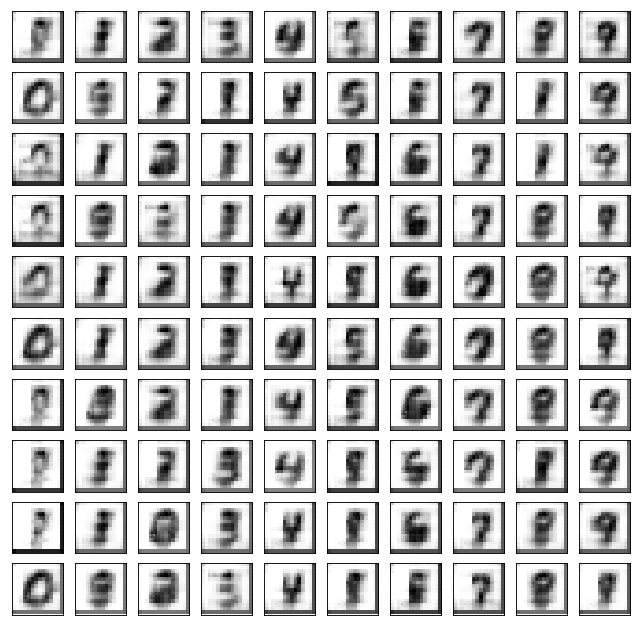

Test losses: CVAE_2: 0.3136/0.8617
Train Epoch: 2 [0/50000 (0%)]	Losses CVAE_2: 0.3142
Train Epoch: 2 [10000/50000 (20%)]	Losses CVAE_2: 0.2838
Train Epoch: 2 [20000/50000 (40%)]	Losses CVAE_2: 0.2650
Train Epoch: 2 [30000/50000 (60%)]	Losses CVAE_2: 0.2394
Train Epoch: 2 [40000/50000 (80%)]	Losses CVAE_2: 0.2203
Train Epoch: 2 [50000/50000 (100%)]	Losses CVAE_2: 0.2003
Reconstructed images:


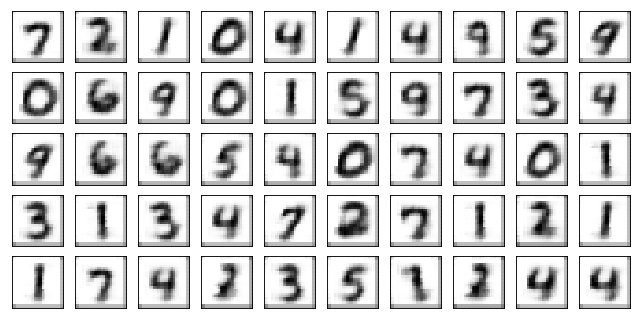

Generated images:


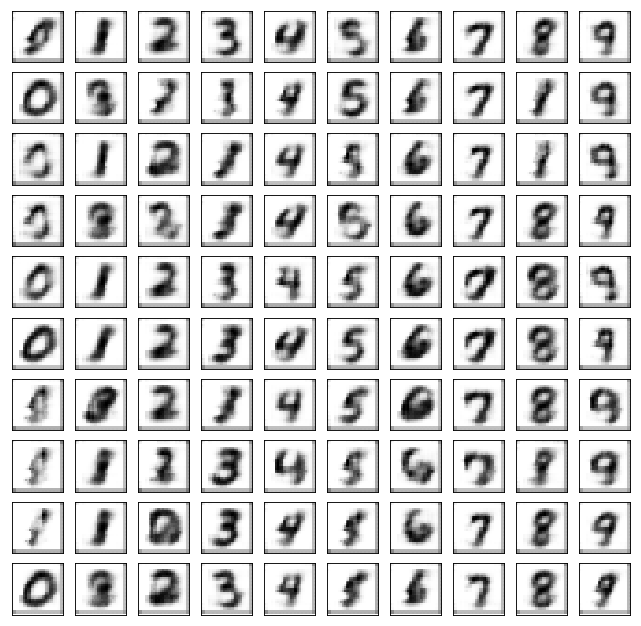

Test losses: CVAE_2: 0.2049/1.7430
Train Epoch: 3 [0/50000 (0%)]	Losses CVAE_2: 0.2204
Train Epoch: 3 [10000/50000 (20%)]	Losses CVAE_2: 0.2289
Train Epoch: 3 [20000/50000 (40%)]	Losses CVAE_2: 0.2169
Train Epoch: 3 [30000/50000 (60%)]	Losses CVAE_2: 0.1803
Train Epoch: 3 [40000/50000 (80%)]	Losses CVAE_2: 0.1786
Train Epoch: 3 [50000/50000 (100%)]	Losses CVAE_2: 0.1901
Reconstructed images:


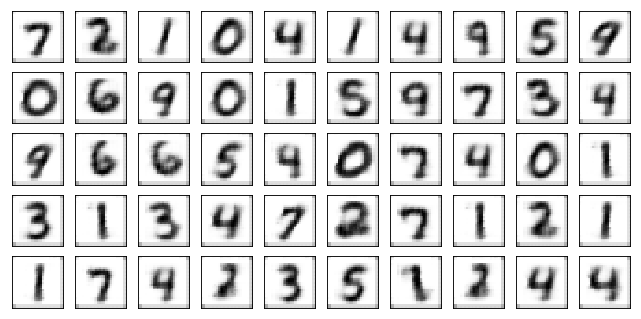

Generated images:


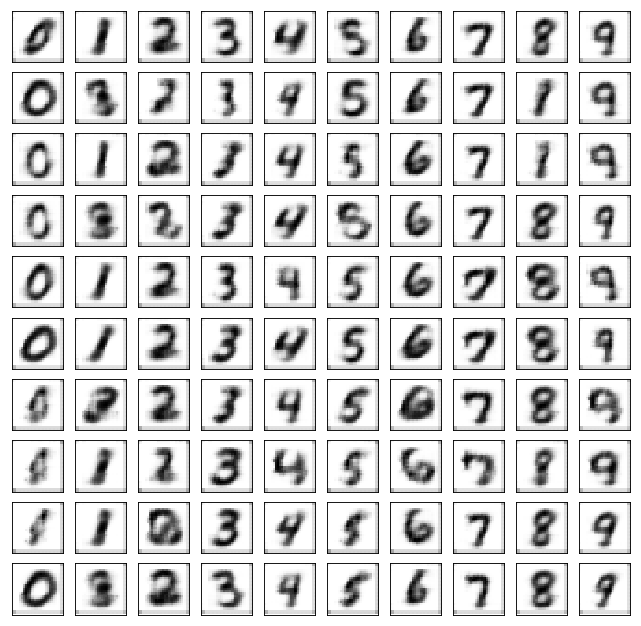

Test losses: CVAE_2: 0.1722/1.8352
Train Epoch: 4 [0/50000 (0%)]	Losses CVAE_2: 0.1782
Train Epoch: 4 [10000/50000 (20%)]	Losses CVAE_2: 0.1673
Train Epoch: 4 [20000/50000 (40%)]	Losses CVAE_2: 0.1898
Train Epoch: 4 [30000/50000 (60%)]	Losses CVAE_2: 0.1819
Train Epoch: 4 [40000/50000 (80%)]	Losses CVAE_2: 0.1677
Train Epoch: 4 [50000/50000 (100%)]	Losses CVAE_2: 0.1669
Reconstructed images:


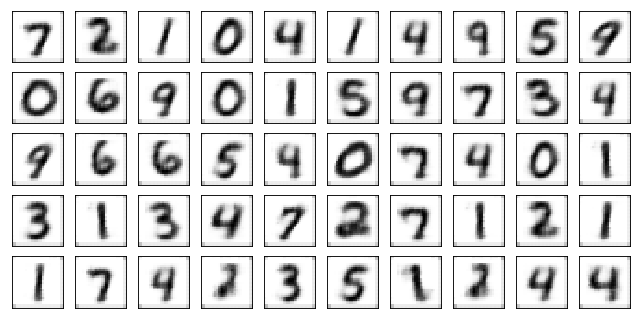

Generated images:


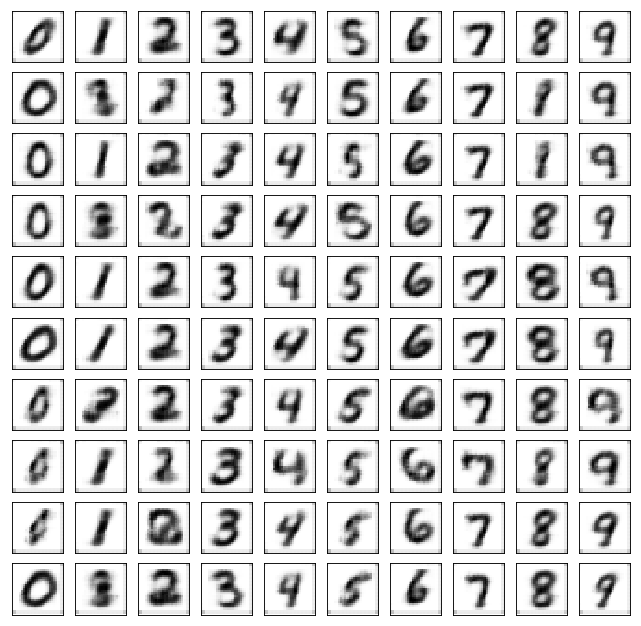

Test losses: CVAE_2: 0.1611/1.9915
Train Epoch: 5 [0/50000 (0%)]	Losses CVAE_2: 0.1854
Train Epoch: 5 [10000/50000 (20%)]	Losses CVAE_2: 0.1789
Train Epoch: 5 [20000/50000 (40%)]	Losses CVAE_2: 0.1642
Train Epoch: 5 [30000/50000 (60%)]	Losses CVAE_2: 0.1793
Train Epoch: 5 [40000/50000 (80%)]	Losses CVAE_2: 0.1759
Train Epoch: 5 [50000/50000 (100%)]	Losses CVAE_2: 0.1657
Reconstructed images:


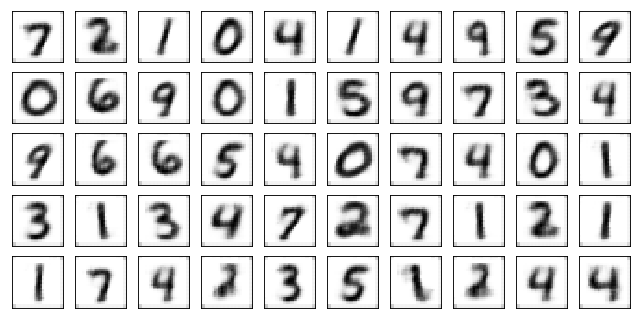

Generated images:


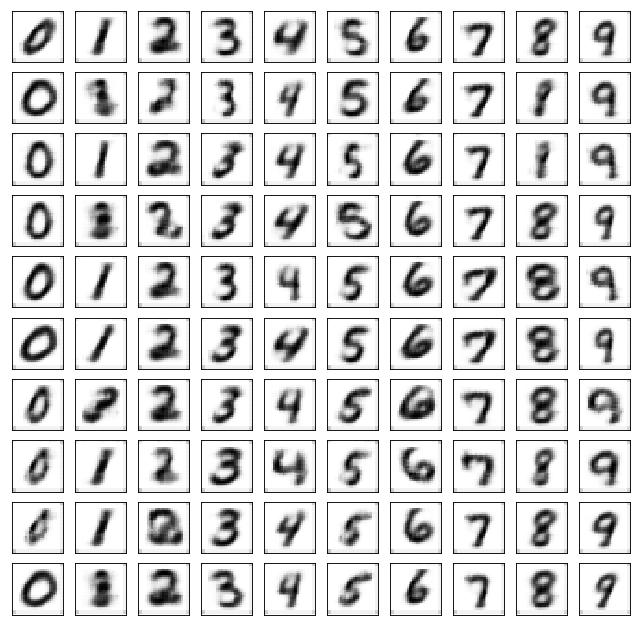

Test losses: CVAE_2: 0.1561/2.0666
Train Epoch: 6 [0/50000 (0%)]	Losses CVAE_2: 0.1566
Train Epoch: 6 [10000/50000 (20%)]	Losses CVAE_2: 0.1560
Train Epoch: 6 [20000/50000 (40%)]	Losses CVAE_2: 0.1738
Train Epoch: 6 [30000/50000 (60%)]	Losses CVAE_2: 0.1500
Train Epoch: 6 [40000/50000 (80%)]	Losses CVAE_2: 0.1734
Train Epoch: 6 [50000/50000 (100%)]	Losses CVAE_2: 0.1673
Reconstructed images:


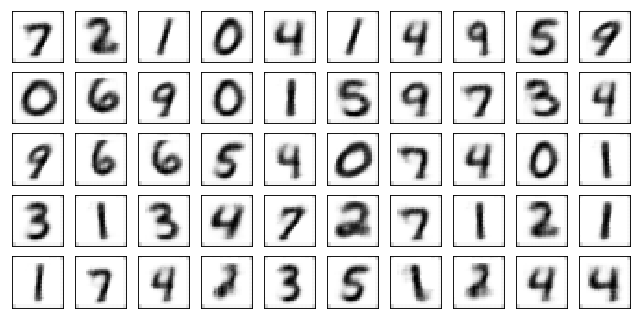

Generated images:


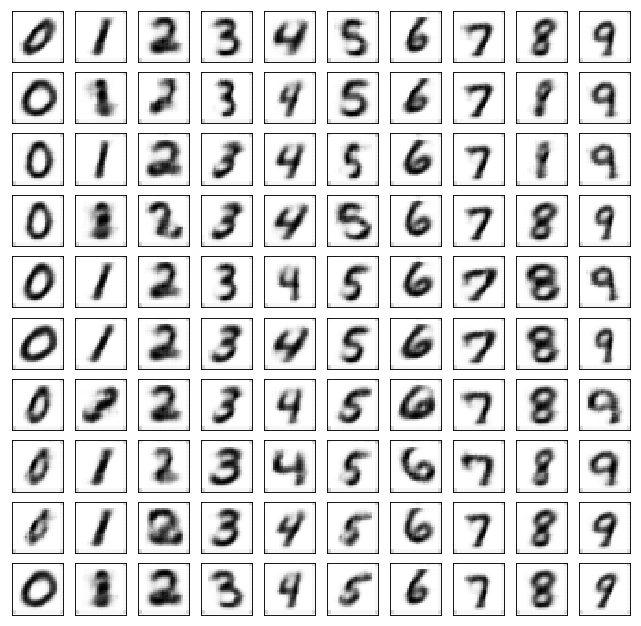

Test losses: CVAE_2: 0.1525/2.0520
Train Epoch: 7 [0/50000 (0%)]	Losses CVAE_2: 0.1614


KeyboardInterrupt: 

In [533]:
for epoch in range(1, 31):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, epoch, test_log)